In [ ]:
import os
import json
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

RAW_DIR = "/home/zhengxiang/FlightRank/data/raw"
OUTPUT_FILE = "/home/zhengxiang/FlightRank/data/raw_summary.parquet"


def extract_fields_from_json(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except (json.JSONDecodeError, OSError) as e:
        return None

    metadata = data.get("metadata", {})
    personal_data = data.get("personalData", {})
    return {
        "ranker_id": os.path.splitext(os.path.basename(file_path))[0],
        "searchType": metadata.get("searchType"),
        "yearOfBirth": personal_data.get("yearOfBirth"),
        "hasAssistant": personal_data.get("hasAssistant"),
        "isGlobal": personal_data.get("isGlobal"),
    }


def main():
    json_files = [
        os.path.join(RAW_DIR, f) for f in os.listdir(RAW_DIR) if f.endswith(".json")
    ]

    results = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = {
            executor.submit(extract_fields_from_json, fp): fp for fp in json_files
        }
        for future in tqdm(as_completed(futures), total=len(json_files)):
            result = future.result()
            if result:
                results.append(result)

    if results:
        pd.DataFrame(results).to_parquet(OUTPUT_FILE, index=False)
        print(f"保存完成: {OUTPUT_FILE}")
    else:
        print("未找到任何有效 JSON 文件！")


# if __name__ == "__main__":
#     main()

In [1]:
import polars as pl

df = pl.read_parquet("./data/label.parquet")
print(df)

shape: (21_347_281, 17)
┌────────────┬────────┬────────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ ranker_id  ┆ row_id ┆ totalPrice ┆ category ┆ … ┆ supplier   ┆ canBuyAdd ┆ flight_ca ┆ ticket_de │
│ ---        ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---        ┆ Ser       ┆ tegory    ┆ signator  │
│ str        ┆ i64    ┆ f64        ┆ i64      ┆   ┆ str        ┆ ---       ┆ ---       ┆ ---       │
│            ┆        ┆            ┆          ┆   ┆            ┆ bool      ┆ i64       ┆ null      │
╞════════════╪════════╪════════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ b960cbc710 ┆ 1      ┆ 8150.0     ┆ 283      ┆ … ┆ a1e6a000-e ┆ false     ┆ 1         ┆ null      │
│ b64950b1d7 ┆        ┆            ┆          ┆   ┆ ba1-bab0-d ┆           ┆           ┆           │
│ 6d1f06ab79 ┆        ┆            ┆          ┆   ┆ ead-bab1be ┆           ┆           ┆           │
│ …          ┆        ┆            ┆          ┆   ┆ …          ┆   

In [3]:
df_filtered = df.filter(pl.col("labels").list.contains("Convenience"))
print(df_filtered)

shape: (123_379, 17)
┌────────────┬────────┬────────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ ranker_id  ┆ row_id ┆ totalPrice ┆ category ┆ … ┆ supplier   ┆ canBuyAdd ┆ flight_ca ┆ ticket_de │
│ ---        ┆ ---    ┆ ---        ┆ ---      ┆   ┆ ---        ┆ Ser       ┆ tegory    ┆ signator  │
│ str        ┆ i64    ┆ f64        ┆ i64      ┆   ┆ str        ┆ ---       ┆ ---       ┆ ---       │
│            ┆        ┆            ┆          ┆   ┆            ┆ bool      ┆ i64       ┆ null      │
╞════════════╪════════╪════════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ b960cbc710 ┆ 1      ┆ 8150.0     ┆ 283      ┆ … ┆ a1e6a000-e ┆ false     ┆ 1         ┆ null      │
│ b64950b1d7 ┆        ┆            ┆          ┆   ┆ ba1-bab0-d ┆           ┆           ┆           │
│ 6d1f06ab79 ┆        ┆            ┆          ┆   ┆ ead-bab1be ┆           ┆           ┆           │
│ …          ┆        ┆            ┆          ┆   ┆ …          ┆      

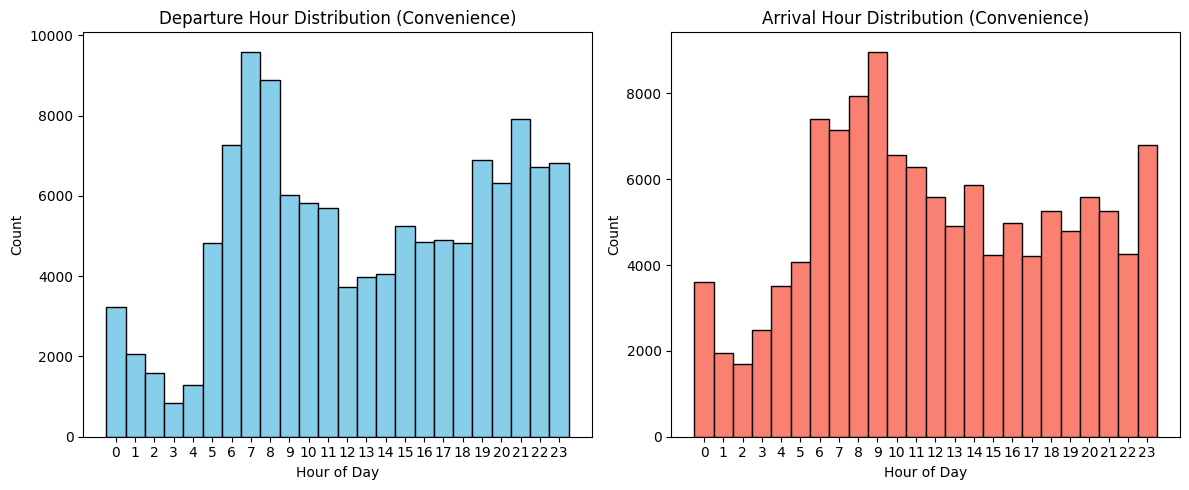

In [4]:
import matplotlib.pyplot as plt

df_hours = df_filtered.select(
    [
        pl.col("legs0_departureAt")
        .str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S")
        .dt.hour()
        .alias("departure_hour"),
        pl.col("legs0_arrivalAt")
        .str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S")
        .dt.hour()
        .alias("arrival_hour"),
    ]
)

# 转为 pandas
departure_hours = df_hours["departure_hour"].to_pandas()
arrival_hours = df_hours["arrival_hour"].to_pandas()

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(
    departure_hours.dropna(),
    bins=range(25),
    color="skyblue",
    edgecolor="black",
    align="left",
)
plt.xticks(range(0, 24))
plt.title("Departure Hour Distribution (Convenience)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(
    arrival_hours.dropna(),
    bins=range(25),
    color="salmon",
    edgecolor="black",
    align="left",
)
plt.xticks(range(0, 24))
plt.title("Arrival Hour Distribution (Convenience)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [4]:
import os, json
import polars as pl


def extract_fields_from_json(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except (json.JSONDecodeError, OSError) as e:
        return None

    all_labels = []

    for flight in data["data"]["$values"]:
        flight_id = flight["id"]
        for pricing in flight.get("pricings", []):
            pricing_id = pricing["id"]
            labels = pricing.get("labels", [])
            all_labels.append(
                {"flight_id": flight_id, "pricing_id": pricing_id, "labels": labels}
            )

    return all_labels

In [8]:
file_path = "/home/zhengxiang/FlightRank/data/raw/fff23aff1b224e1c8612408c302a60f4.json"
json_res = extract_labels_from_json(file_path)
for res in json_res:
    print(res)

{'ranker_id': 'fff23aff1b224e1c8612408c302a60f4', 'row_id': 1, 'totalPrice': 35327.0, 'category': 27, 'legs0_departureAt': '2024-08-19T12:30:00', 'legs0_arrivalAt': '2024-08-19T16:20:00', 'legs1_departureAt': '2024-08-23T06:00:00', 'legs1_arrivalAt': '2024-08-23T12:55:00', 'legs0_segments0_flightNumber': '1211', 'legs1_segments0_flightNumber': '1835', 'legs0_segments1_flightNumber': '1836', 'legs1_segments1_flightNumber': '1218', 'labels': ['BestPrice', 'BestPriceTravelPolicy', 'BestPriceCorporateTariff', 'Convenience'], 'supplier': 'e294cac4-ea1b-4431-bc5c-464118070816', 'canBuyAddSer': False, 'flight_category': 0, 'ticket_designator': None}
{'ranker_id': 'fff23aff1b224e1c8612408c302a60f4', 'row_id': 2, 'totalPrice': 42132.0, 'category': 0, 'legs0_departureAt': '2024-08-19T12:30:00', 'legs0_arrivalAt': '2024-08-19T16:20:00', 'legs1_departureAt': '2024-08-23T06:00:00', 'legs1_arrivalAt': '2024-08-23T12:55:00', 'legs0_segments0_flightNumber': '1211', 'legs1_segments0_flightNumber': '183

In [ ]:
import os
import ijson
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

RAW_DIR = "/home/zhengxiang/FlightRank/data/raw"
OUTPUT_FILE = "/home/zhengxiang/FlightRank/data/label.parquet"


def extract_labels_from_json(file_path):
    ranker_id = os.path.splitext(os.path.basename(file_path))[0]
    results = []
    # group_id = 0
    try:
        with open(file_path, "rb") as f:
            flights = ijson.items(f, "data.$values.item")
            for flight in flights:
                legs = flight.get("legs", [])

                for pricing in flight.get("pricings", []):
                    results.append(
                        {
                            "ranker_id": ranker_id,
                            # "group_id": group_id,
                            "row_id": pricing.get("ordinal", 0) + 1,
                            "totalPrice": float(pricing.get("totalPrice", 0.0)),
                            "category": pricing.get("category", None),
                            "labels": pricing.get("labels", []),
                        }
                    )
                # group_id += 1
    except Exception as e:
        print(f"Error: {e}")
    return results


def main():
    json_files = [
        os.path.join(RAW_DIR, f) for f in os.listdir(RAW_DIR) if f.endswith(".json")
    ]

    all_results = []
    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {
            executor.submit(extract_labels_from_json, fp): fp for fp in json_files
        }
        for future in tqdm(as_completed(futures), total=len(json_files)):
            result = future.result()
            if result:
                all_results.extend(result)

    return pd.DataFrame(all_results)


if __name__ == "__main__":
    extract_df = main()

100%|██████████| 150770/150770 [01:59<00:00, 1265.29it/s]


In [11]:
print(len(extract_df))

21347281


In [12]:
print(extract_df.head())

                          ranker_id  row_id  totalPrice  category  \
0  b960cbc710b64950b1d76d1f06ab7968       1      8150.0       283   
1  b960cbc710b64950b1d76d1f06ab7968       2     10205.0       256   
2  b960cbc710b64950b1d76d1f06ab7968       3     25660.0       256   
3  99d7fb3f49c642f0b4d45d2156271d56       1      3717.0        15   
4  99d7fb3f49c642f0b4d45d2156271d56       2      4317.0         0   

     legs0_departureAt      legs0_arrivalAt legs1_departureAt legs1_arrivalAt  \
0  2024-09-28T04:45:00  2024-09-28T08:10:00              None            None   
1  2024-09-28T04:45:00  2024-09-28T08:10:00              None            None   
2  2024-09-28T04:45:00  2024-09-28T08:10:00              None            None   
3  2024-09-23T23:55:00  2024-09-24T01:30:00              None            None   
4  2024-09-23T23:55:00  2024-09-24T01:30:00              None            None   

  legs0_segments0_flightNumber legs1_segments0_flightNumber  \
0                         5310     

In [13]:
extract_df.to_parquet("/home/zhengxiang/FlightRank/data/label.parquet")

In [1]:
import polars as pl

OUTPUT_FILE = "/home/zhengxiang/FlightRank/data/label.parquet"
# df = pl.read_csv(OUTPUT_FILE, schema_overrides={"totalPrice": pl.Float64})
df = pl.read_parquet(OUTPUT_FILE)
print(df)

shape: (21_347_281, 4)
┌─────────────────────────────────┬────────┬──────────┬─────────────────────────────────┐
│ ranker_id                       ┆ row_id ┆ category ┆ labels                          │
│ ---                             ┆ ---    ┆ ---      ┆ ---                             │
│ str                             ┆ i64    ┆ i64      ┆ list[str]                       │
╞═════════════════════════════════╪════════╪══════════╪═════════════════════════════════╡
│ 8d114ce973cf41c4907f5f7f4fd6a6… ┆ 0      ┆ 23       ┆ ["BestPrice", "BestPriceTravel… │
│ 8d114ce973cf41c4907f5f7f4fd6a6… ┆ 1      ┆ 0        ┆ []                              │
│ 8d114ce973cf41c4907f5f7f4fd6a6… ┆ 2      ┆ 0        ┆ []                              │
│ 8d114ce973cf41c4907f5f7f4fd6a6… ┆ 3      ┆ 264      ┆ ["BestPriceCorporateTariff", "… │
│ 8d114ce973cf41c4907f5f7f4fd6a6… ┆ 4      ┆ 256      ┆ ["MinTime"]                     │
│ …                               ┆ …      ┆ …        ┆ …                    

In [14]:
extract_df = df.group_by(["ranker_id"]).agg(pl.len())

In [16]:
print(extract_df["supplier"].nunique())

7


In [2]:
group_cols = [
    "ranker_id",
    # "group_id",
    "legs0_departureAt",
    "legs0_arrivalAt",
    "legs1_departureAt",
    "legs1_arrivalAt",
]

# 选择这些列进行填充
df = df.with_columns(
    [
        pl.col("legs1_departureAt").fill_null("missing"),
        pl.col("legs1_arrivalAt").fill_null("missing"),
        pl.col("legs0_departureAt").fill_null("missing"),
        pl.col("legs0_arrivalAt").fill_null("missing"),
    ]
)

# 然后 group_by 和 join 操作就不会因 null 产生意外行为了
group_df = df.group_by(group_cols).agg(pl.len().alias("count_df"))
print(group_df)

shape: (7_048_458, 6)
┌─────────────────┬─────────────────┬─────────────────┬────────────────┬────────────────┬──────────┐
│ ranker_id       ┆ legs0_departure ┆ legs0_arrivalAt ┆ legs1_departur ┆ legs1_arrivalA ┆ count_df │
│ ---             ┆ At              ┆ ---             ┆ eAt            ┆ t              ┆ ---      │
│ str             ┆ ---             ┆ str             ┆ ---            ┆ ---            ┆ u32      │
│                 ┆ str             ┆                 ┆ str            ┆ str            ┆          │
╞═════════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╪══════════╡
│ 55ba498fbff4417 ┆ 2024-10-31T15:2 ┆ 2024-11-01T15:0 ┆ 2024-11-16T06: ┆ 2024-11-17T13: ┆ 4        │
│ 5a4835b8aa8e314 ┆ 0:00            ┆ 5:00            ┆ 50:00          ┆ 55:00          ┆          │
│ …               ┆                 ┆                 ┆                ┆                ┆          │
│ f3a3e3120e3148d ┆ 2024-10-31T07:0 ┆ 2024-10-31T08:3 ┆ 2024-11-02T18

In [14]:
label_df = pl.read_parquet("./data/label_tmp.parquet")

label_df = label_df.rename(
    {
        "legs0_segs0_flightNumber": "legs0_segments0_flightNumber",
        "legs1_segs0_flightNumber": "legs1_segments0_flightNumber",
    }
)

fill_str_cols = [
    "legs0_segments0_flightNumber",
    "legs1_segments0_flightNumber",
    "legs0_departureAt",
    "legs0_arrivalAt",
    "legs1_departureAt",
    "legs1_arrivalAt",
]


for col in fill_str_cols:
    label_df = label_df.with_columns(pl.col(col).fill_null("missing"))

In [15]:
import os

train = pl.read_parquet(os.path.join("data", "train.parquet")).drop("__index_level_0__")
test = (
    pl.read_parquet(os.path.join("data", "test.parquet"))
    .drop("__index_level_0__")
    .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
)

raw = pl.concat((train, test))

for col in fill_str_cols:
    raw = raw.with_columns(pl.col(col).fill_null("missing"))


raw = raw.select(
    [
        "ranker_id",
        "totalPrice",
    ]
    + fill_str_cols
)

raw = raw.join(
    label_df,
    on=[
        "ranker_id",
        "legs0_segments0_flightNumber",
        "legs1_segments0_flightNumber",
        "totalPrice",
        "legs0_departureAt",
        "legs0_arrivalAt",
        "legs1_departureAt",
        "legs1_arrivalAt",
    ],
    how="inner",
)

In [ ]:
import os

train = pl.read_parquet(os.path.join("data", "train.parquet")).drop("__index_level_0__")
test = (
    pl.read_parquet(os.path.join("data", "test.parquet"))
    .drop("__index_level_0__")
    .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
)

train_test = pl.concat((train, test))


train_test_df = train_test.group_by(
    [
        "ranker_id",
        # "legs0_duration",
        # "legs1_duration",
        # "legs0_departureAt",
        # "legs0_arrivalAt",
        # "legs1_departureAt",
        # "legs1_arrivalAt",
        # "legs0_segments0_flightNumber",
        # "legs1_segments0_flightNumber",
    ]
).agg(pl.len())

print(train_test_df)

18145372
shape: (150_770, 2)
┌─────────────────────────────────┬──────┐
│ ranker_id                       ┆ len  │
│ ---                             ┆ ---  │
│ str                             ┆ u32  │
╞═════════════════════════════════╪══════╡
│ b3fcd012a59a445890995e86b48a14… ┆ 25   │
│ 094aefc664d04d70bc1d38617dffe8… ┆ 58   │
│ 8cada042cdc342b59d701132e75591… ┆ 69   │
│ bb1d19853f77423faf8141f071a2c2… ┆ 304  │
│ 467f90e4347b4d238d3465a3527b5f… ┆ 63   │
│ …                               ┆ …    │
│ 208abeddae264678b2ac4079aaa520… ┆ 12   │
│ a48902f6160d455f8a19d76e83c119… ┆ 26   │
│ 9709b8b6adb3496eb79a382cbfa8cb… ┆ 1    │
│ 79a267d4ea824b6c986f46d61f1f34… ┆ 1588 │
│ 737b457ee52143a4a3a5872fb10451… ┆ 92   │
└─────────────────────────────────┴──────┘


In [17]:
code_df = train_test_df.join(extract_df, on="ranker_id", how="inner")
code_df = code_df.with_columns((pl.col("len_right") - pl.col("len")).alias("len_df"))
print(code_df)

shape: (126_357, 4)
┌─────────────────────────────────┬──────┬───────────┬────────┐
│ ranker_id                       ┆ len  ┆ len_right ┆ len_df │
│ ---                             ┆ ---  ┆ ---       ┆ ---    │
│ str                             ┆ u32  ┆ u32       ┆ u32    │
╞═════════════════════════════════╪══════╪═══════════╪════════╡
│ 094aefc664d04d70bc1d38617dffe8… ┆ 58   ┆ 58        ┆ 0      │
│ 8cada042cdc342b59d701132e75591… ┆ 69   ┆ 69        ┆ 0      │
│ bb1d19853f77423faf8141f071a2c2… ┆ 304  ┆ 304       ┆ 0      │
│ 467f90e4347b4d238d3465a3527b5f… ┆ 63   ┆ 63        ┆ 0      │
│ 7913e57e519f4ec5b8a123e7afe7f0… ┆ 1905 ┆ 1905      ┆ 0      │
│ …                               ┆ …    ┆ …         ┆ …      │
│ a3ca945bf4aa43ddbcd1065ea6dbcf… ┆ 23   ┆ 23        ┆ 0      │
│ 208abeddae264678b2ac4079aaa520… ┆ 12   ┆ 12        ┆ 0      │
│ a48902f6160d455f8a19d76e83c119… ┆ 26   ┆ 26        ┆ 0      │
│ 9709b8b6adb3496eb79a382cbfa8cb… ┆ 1    ┆ 1         ┆ 0      │
│ 737b457ee52143a4a3

In [ ]:
def cols_equal(col_name):
    left = pl.col(col_name)
    right = pl.col(f"{col_name}_right")
    return (left == right) | (left.is_null() & right.is_null())


raw = raw.with_columns(
    [
        cols_equal("totalPrice").alias("totalPrice_equal"),
        cols_equal("legs0_departureAt").alias("legs0_departureAt_equal"),
        cols_equal("legs0_arrivalAt").alias("legs0_arrivalAt_equal"),
        cols_equal("legs1_departureAt").alias("legs1_departureAt_equal"),
        cols_equal("legs1_arrivalAt").alias("legs1_arrivalAt_equal"),
    ]
)

raw = raw.with_columns(
    (
        pl.col("totalPrice_equal")
        & pl.col("legs0_departureAt_equal")
        & pl.col("legs0_arrivalAt_equal")
        & pl.col("legs1_departureAt_equal")
        & pl.col("legs1_arrivalAt_equal")
    ).alias("all_fields_equal")
)

# raw = raw.select(["ranker_id", "row_id", "totalPrice", "totalPrice_right", "totalPrice_equal", "all_fields_equal"])

In [15]:
raw_display = raw.select(["ranker_id", "row_id", "group_id", "totalPrice"])
print(raw_display)

shape: (22_429_111, 4)
┌─────────────────────────────────┬────────┬──────────┬────────────┐
│ ranker_id                       ┆ row_id ┆ group_id ┆ totalPrice │
│ ---                             ┆ ---    ┆ ---      ┆ ---        │
│ str                             ┆ i64    ┆ i64      ┆ f64        │
╞═════════════════════════════════╪════════╪══════════╪════════════╡
│ 98ce0dabf6964640b63079fbafd42c… ┆ 0      ┆ 0        ┆ 16884.0    │
│ 98ce0dabf6964640b63079fbafd42c… ┆ 1      ┆ 1        ┆ 51125.0    │
│ 98ce0dabf6964640b63079fbafd42c… ┆ 2      ┆ 1        ┆ 53695.0    │
│ 98ce0dabf6964640b63079fbafd42c… ┆ 3      ┆ 1        ┆ 81880.0    │
│ 98ce0dabf6964640b63079fbafd42c… ┆ 4      ┆ 1        ┆ 86070.0    │
│ …                               ┆ …      ┆ …        ┆ …          │
│ 302475b6405d464eaf01a85cf496e2… ┆ 9      ┆ 2        ┆ 69911.0    │
│ 302475b6405d464eaf01a85cf496e2… ┆ 10     ┆ 3        ┆ 54738.0    │
│ 302475b6405d464eaf01a85cf496e2… ┆ 11     ┆ 4        ┆ 78743.0    │
│ 623cd1155

In [21]:
group_raw = raw.group_by(
    [
        "ranker_id",
        "group_id",
    ]
).agg(pl.len().alias("count_raw"))

In [22]:
diff = group_df.join(group_raw, on=["ranker_id", "group_id"], how="outer")

# 增加差异列
diff = diff.with_columns((pl.col("count_df") - pl.col("count_raw")).alias("count_diff"))

diff = diff.select(["ranker_id", "count_diff"])
# 查看有差异的行
# diff.filter(pl.col("count_diff") != 0).sort("count_diff", descending=True).show()

/tmp/ipykernel_2547630/4193525889.py:1: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  diff = group_df.join(group_raw, on=[


In [6]:
import polars as pl

all_labels = df.select(pl.col("labels").explode()).unique().to_series().to_list()
print(set(all_labels))

{'BestPrice', None, 'BestPriceTravelPolicy', 'BestPriceDirect', 'Convenience', 'MinTime', 'BestPriceCorporateTariff'}


In [5]:
import os
import polars as pl

train = pl.read_parquet(os.path.join("data", "train.parquet")).drop("__index_level_0__")

df = train

label_df = pl.read_parquet("./data/label.parquet")

df = df.with_columns(pl.arange(0, pl.len()).over("ranker_id").alias("row_id"))

# join
df = df.join(
    label_df.select(["ranker_id", "row_id", "labels", "category"]),
    on=["ranker_id", "row_id"],
    how="left",
)

df = df.with_columns(pl.col("labels").list.len().log1p().alias("labels_count"))

df = df.with_columns(
    (pl.col("labels").list.len() > 0).cast(pl.Int8).alias("has_any_label")
)

df = df.filter(pl.col("selected") == 1)
df = df.drop(["labels"]).select(
    ["Id", "row_id", "ranker_id", "category", "has_any_label"]
)

/tmp/ipykernel_2696938/3601943820.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  df = df.with_columns(pl.arange(0, pl.count()).over("ranker_id").alias("row_id"))


0.5387


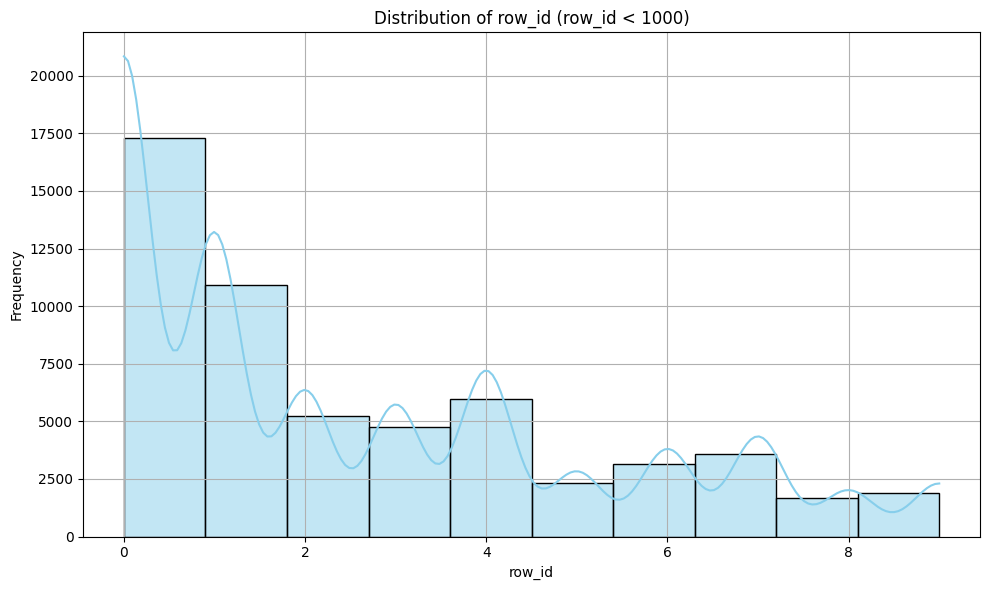

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 转为 pandas
df_pd = df.to_pandas()

total_selected = len(df_pd)

# 仅保留 row_id < 1000 的数据
df_pd = df_pd[df_pd["row_id"] < 10]

print(f"{len(df_pd) / total_selected:.4f}")

# 画图
plt.figure(figsize=(10, 6))
sns.histplot(df_pd["row_id"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of row_id (row_id < 1000)")
plt.xlabel("row_id")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import os
import ijson
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

RAW_DIR = "/home/zhengxiang/FlightRank/data/raw"
OUTPUT_FILE = "/home/zhengxiang/FlightRank/data/ranker.parquet"


def extract_ranker_infos_from_json(file_path):
    ranker_id = os.path.splitext(os.path.basename(file_path))[0]
    result = {
        "ranker_id": ranker_id,
        "searchType": None,
        "yearOfBirth": None,
        "hasAssistant": None,
        "isGlobal": None,
    }

    try:
        with open(file_path, "rb") as f:
            parser = ijson.parse(f)
            for prefix, event, value in parser:
                if prefix == "metadata.searchType" and event == "number":
                    result["searchType"] = value
                elif prefix == "personalData.yearOfBirth" and event == "number":
                    result["yearOfBirth"] = value
                elif prefix == "personalData.hasAssistant" and event == "boolean":
                    result["hasAssistant"] = value
                elif prefix == "personalData.isGlobal" and event == "boolean":
                    result["isGlobal"] = value
                if all(v is not None for v in result.values() if v != "ranker_id"):
                    break
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

    return result


def main():
    json_files = [
        os.path.join(RAW_DIR, f) for f in os.listdir(RAW_DIR) if f.endswith(".json")
    ]

    all_results = []
    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {
            executor.submit(extract_ranker_infos_from_json, fp): fp for fp in json_files
        }
        for future in tqdm(as_completed(futures), total=len(json_files)):
            result = future.result()
            if result:
                all_results.append(result)

    return pd.DataFrame(all_results)


if __name__ == "__main__":
    extract_df = main()

100%|██████████| 150770/150770 [00:16<00:00, 8957.92it/s]


In [5]:
print(extract_df)

                               ranker_id  searchType  yearOfBirth  \
0       5bf9a57437be46ad976dfbe11c88ba46           1       1995.0   
1       030d6aca70de4758b44df26a155af63b           1       1970.0   
2       b960cbc710b64950b1d76d1f06ab7968           1       1993.0   
3       6cc70bcec3f5454d819f133682656463           1       1978.0   
4       759b341c10704f609f8085ee3057f6fd           0       1981.0   
...                                  ...         ...          ...   
150765  84cd5ffde326470781a1944171c793e6           1       1970.0   
150766  5f31c0780d9e4029ac1e787a6ad63b64           1       1977.0   
150767  c5ee207cd42f438d9c2adcd80278f4e4           1       1967.0   
150768  304729a89c5d449781476042e07ee6c4           1       1979.0   
150769  843d29a23e8344f8a80b4876da616b20           1       1984.0   

        hasAssistant  isGlobal  
0              False     False  
1              False     False  
2              False     False  
3              False     False  
4     

In [7]:
extract_df.to_parquet(OUTPUT_FILE)